# Product Recommendation Systems

### Domain - E-commerce
### Context - 
Everyday a million products are being recommended to users based on
popularity and other metrics on e-commerce websites. The most popular e-commerce
website boosts average order value by 50%, increases revenues by 300%, and
improves conversion. In addition to being a powerful tool for increasing revenues,
product recommendations are so essential that customers now expect to see similar
features on all other eCommerce sites.

### Data Description -
Data columns- First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.
### Source - 
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics
dataset.

### Learning Outcomes -
● Exploratory Data Analysis <br>
● Data Wrangling <br>
● Build a Popularity recommender model <br>
● Build Collaborative Filtering model <br>
### Objective - 
To make a recommendation system that recommends at least five(5) new products based on the user's habits.
### Steps and tasks -
#### 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics) ( 3 Marks)

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")

In [342]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [343]:
import os
os.getcwd()

'/content'

In [344]:
recom_df=pd.read_csv('/content/drive/My Drive/Recommendation systems/ratings_Electronics.csv',header=None,names=['userId', 'productId', 'ratings'],usecols=[0,1,2])

In [345]:
df=recom_df.copy()

In [346]:
df.head(5)

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [347]:
df.shape

(7824482, 3)

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [349]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userId,7824482,4201696,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productId,7824482,476002,B0074BW614,18244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratings,7.82448e+06,NaN,NaN,NaN,4.01234,1.38091,1,3,5,5,5


In [350]:
# To check if any missing(NaN) values are present
df.isna().values.any()

False

In [351]:
# Function for creating histogram and box-plot side by side for continuous variables
# Histogram plot is to help in understanding the distribution of the feature
# Box-plot is to see the data spread across quantiles and also to identify outliers if any
def numerical_feature_plot(feature):
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,6))
    sns.distplot(df[feature],ax=ax[0])
    ax[0].set_title("Histogram of "+feature)
    sns.boxplot(y=df[feature],ax=ax[1])
    ax[1].set_title("Boxplot of "+feature)

In [352]:
def numerical_feature_analysis(feature):
    feature_min=df[feature].min()
    feature_max=df[feature].max()
    feature_q1=np.quantile(df[feature],0.25)
    feature_q3=np.quantile(df[feature],0.75)
    feature_IQR=(feature_q3-feature_q1)
    feature_lower_whisker=feature_q1-(feature_IQR*1.5)
    feature_upper_whisker=feature_q3+(feature_IQR*1.5)

    print("Feature: ",feature)
    if (feature_lower_whisker<=feature_min) and (feature_upper_whisker>=feature_max):
        print("No outliers.")
    else:
        if (feature_upper_whisker<feature_max):
            print("Outliers are present in maximum. ",feature," above ",round(feature_upper_whisker,2)," are outliers and total are ",df[df[feature]>feature_upper_whisker][feature].count())
        if (feature_lower_whisker>feature_min):
            print("Outliers are present in minimum. ",feature," below ",round(feature_lower_whisker,2)," are outliers and total are ",df[df[feature]<feature_lower_whisker][feature].count())
    
    print("----------------------------------------------------------------------------------------------")

In [353]:
numerical_feature_list=list(df.select_dtypes(exclude='object').columns)
categorical_feature_list=list(df.select_dtypes(include='object').columns)

print("Numerical Features: ",numerical_feature_list)
print("Categorical Features: ",categorical_feature_list)

Numerical Features:  ['ratings']
Categorical Features:  ['userId', 'productId']


Feature:  ratings
No outliers.
----------------------------------------------------------------------------------------------


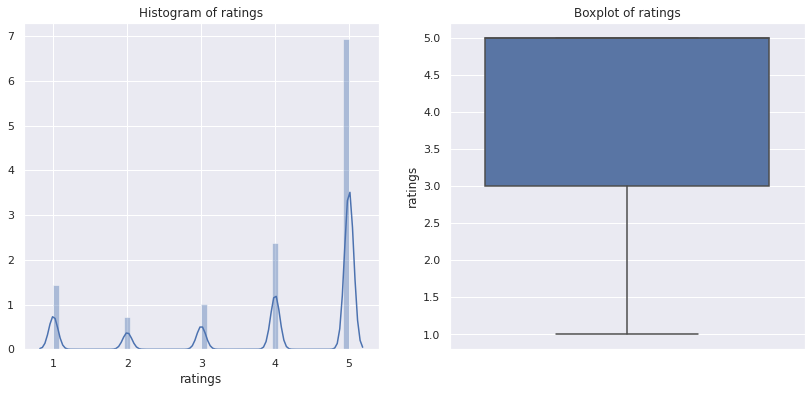

In [354]:
for i in numerical_feature_list:
    numerical_feature_plot(i)
    numerical_feature_analysis(i)

In [355]:
# Check the top10 products that are been rated most.
df.groupby(by='productId',as_index=False).count()[['userId','productId']].rename(columns={'userId':'user_count'}).sort_values(by='user_count',ascending=False).head(10)

,user_count,productId
308398,18244,B0074BW614
429572,16454,B00DR0PDNE
327308,14172,B007WTAJTO
102804,12285,B0019EHU8G
296625,12226,B006GWO5WK
178601,11617,B003ELYQGG
178813,10276,B003ES5ZUU
323013,9907,B007R5YDYA
289775,9823,B00622AG6S
30276,9487,B0002L5R78


#### 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) -(5 Marks)

In [356]:
# Check the top10 users who has rated more no. of products
dfg_users=df.groupby(by='userId',as_index=False).count()[['userId','productId']].sort_values(by='productId',ascending=False).rename(columns={'productId':'prod_count'})
dfg_users.head(10)

,userId,prod_count
3263531,A5JLAU2ARJ0BO,520
3512451,ADLVFFE4VBT8,501
2989526,A3OXHLG6DIBRW8,498
3291008,A6FIAB28IS79,431
3284634,A680RUE1FDO8B,406
755206,A1ODOGXEYECQQ8,380
2424036,A36K2N527TXXJN,314
1451394,A2AY4YUOX2N1BQ,311
4100926,AWPODHOB4GFWL,308
1277963,A25C2M3QF9G7OQ,296


In [357]:
df=pd.merge(left=df,right=dfg_users[dfg_users['prod_count']>=50]['userId'],how='inner',on='userId')
df.head(5)

,userId,productId,ratings
0,A3BY5KCNQZXV5U,0594451647,5.0
1,A3BY5KCNQZXV5U,B00000JD4V,4.0
2,A3BY5KCNQZXV5U,B000063574,5.0
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0
4,A3BY5KCNQZXV5U,B0007Y794O,5.0


In [358]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userId,125871,1540,A5JLAU2ARJ0BO,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
productId,125871,48190,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratings,125871,NaN,NaN,NaN,4.26134,1.06214,1,4,5,5,5


#### 3. Build Popularity Recommender model. ( 15 marks)

Strategy: <br>Considering full dataset for Popular recommendation as we can see that most purchased products are not bought by users who have done 50 or above purchases.

In [359]:
df_full=recom_df.copy()

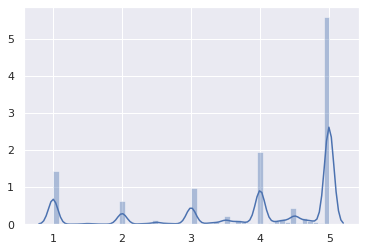

In [360]:
sns.distplot(df_full.groupby(by='userId').mean(),bins=50)

Above mean rating indicates that most of the users have rated majority of the products between 4 and 5.<br> And also there are some significant set of users who have rated majority of their purchased products with least rating 1.

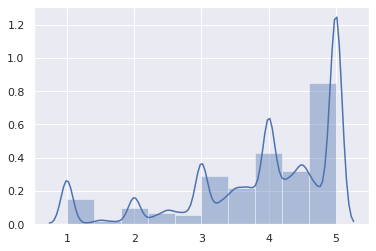

In [361]:
sns.distplot(df_full.groupby(by='productId').mean(),bins=10)

Above indicates that most of the products have their mean rating above 3 which is good. <br> However the spike at rating 1 is alarming which needs to be taken care of.

In [362]:
# Get the count of purchases for each product
dfg_prod_user_counts=df_full.groupby(by='productId',as_index=False).count()[['userId','productId']].rename(columns={'userId':'user_count'})
dfg_prod_user_counts.sort_values(by='user_count',ascending=False).head(10)

,user_count,productId
308398,18244,B0074BW614
429572,16454,B00DR0PDNE
327308,14172,B007WTAJTO
102804,12285,B0019EHU8G
296625,12226,B006GWO5WK
178601,11617,B003ELYQGG
178813,10276,B003ES5ZUU
323013,9907,B007R5YDYA
289775,9823,B00622AG6S
30276,9487,B0002L5R78


In [363]:
# Get the mean rating of each user
dfg_mean_user_rating=df_full.groupby(by='userId',as_index=False).mean()[['userId','ratings']].rename(columns={'ratings':'mean_user_rating'})
dfg_mean_user_rating.sort_values(by='mean_user_rating',ascending=False).head(10)

,userId,mean_user_rating
0,A00000262KYZUE4J55XGL,5.0
1550792,A2E5Z0FJB6EQAX,5.0
3155246,A3UBAAG67M56ET,5.0
1550789,A2E5YU75N551K,5.0
3155247,A3UBAB0AZJQ41O,5.0
3155248,A3UBABSNYPHVLS,5.0
1550786,A2E5YQ26BVDMGJ,5.0
1550785,A2E5YN34J00OY0,5.0
3155249,A3UBACQC3GKPXM,5.0
1550782,A2E5YHLO38AT28,5.0


In [364]:
df_full=pd.merge(left=df_full,right=dfg_mean_user_rating,how='inner',on='userId')

In [365]:
df_full['rating_minus_user_bias']=df_full['ratings']-df_full['mean_user_rating']

In [366]:
df_full.head()

,userId,productId,ratings,mean_user_rating,rating_minus_user_bias
0,AKM1MP6P0OYPR,0132793040,5.0,5.00,0.00
1,AKM1MP6P0OYPR,B005UEB5TQ,5.0,5.00,0.00
2,A2CX7LUOHB2NDG,0321732944,5.0,4.75,0.25
3,A2CX7LUOHB2NDG,B000W3LJ6Y,5.0,4.75,0.25
4,A2CX7LUOHB2NDG,B001EYU79A,5.0,4.75,0.25


In [367]:
# Get the mean rating for each product based on all the purchases done for that product
dfg_prod_user_ratings=df_full.groupby(by='productId',as_index=False).mean()[['productId','rating_minus_user_bias']].rename(columns={'rating_minus_user_bias':'prod_mean_rating'})
#dfg_prod_user_ratings['prod_mean_rating']=np.round(dfg_prod_user_ratings['prod_mean_rating'],0)
dfg_prod_user_ratings.sort_values(by='prod_mean_rating',ascending=False).head(10)

,productId,prod_mean_rating
412832,B00CAZ6HMI,3.428571
15286,B00008IAQ2,3.333333
315119,B007G7CMVK,3.333333
466903,B00I8ILBE0,3.333333
95772,B0014J368O,3.333333
139176,B002BFW4QA,3.333333
55582,B000FNBTP2,3.333333
305530,B00700A7NS,3.250000
97215,B0015IOTSA,3.200000
446870,B00FJW69HW,3.200000


In [368]:
df_popular_set=pd.merge(left=dfg_prod_user_counts,right=dfg_prod_user_ratings,how='inner',on='productId')
df_popular_set.head(10)

,user_count,productId,prod_mean_rating
0,1,0132793040,0.000000
1,1,0321732944,0.250000
2,3,0439886341,0.000000
3,6,0511189877,0.453801
4,27,0528881469,-0.305409
5,1,0558835155,-1.000000
6,3,059400232X,0.000000
7,8,0594012015,-0.291667
8,1,0594017343,0.000000
9,1,0594017580,-1.000000


In [369]:
# Purchase count split based on ratings
df_full['rating_minus_user_bias']=np.round(df_full['rating_minus_user_bias'],0)
df_full.groupby(by='rating_minus_user_bias',as_index=False).count()[['rating_minus_user_bias','userId']].rename(columns={'userId':'ratings_count'})

,rating_minus_user_bias,ratings_count
0,-4.0,5424
1,-3.0,110412
2,-2.0,362951
3,-1.0,519687
4,0.0,5597050
5,1.0,964126
6,2.0,253479
7,3.0,11335
8,4.0,18


Above negative ratings below -2.0 indicates that these are not good products. Because users who rate generously have rated them bad. <br>
Above positive ratings above 2.0 indicates that these are very highly appreciated by users.

In [370]:
# Top 15 products which got bad ratings from even generous customers
df_full[df_full['rating_minus_user_bias']<=-2.0].groupby(by='productId',as_index=False).count()[['productId','userId']].rename(columns={'userId':'purch_Count'}).sort_values(by='purch_Count',ascending=False).head(15)

,productId,purch_Count
123991,B00DR0PDNE,1143
98943,B007WTAJTO,662
90676,B006GWO5WK,468
74852,B004QK7HI8,462
19710,B000I68BD4,457
110679,B009SYZ8OC,425
57365,B003ELYQGG,420
74104,B004OB0EBQ,419
56657,B003D8GAA0,380
47734,B002MAPRYU,378


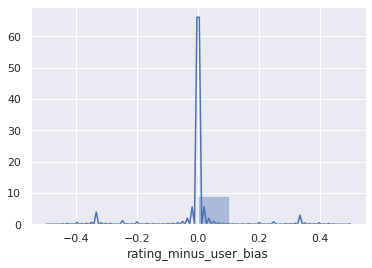

In [371]:
# User Rating distribution plot by removing user-bias
sns.distplot(df_full.groupby(by='userId').mean()['rating_minus_user_bias'],bins=10)

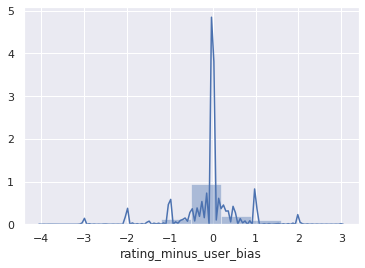

In [372]:
# Product Rating distribution plot by removing user-bias
sns.distplot(df_full.groupby(by='productId').mean()['rating_minus_user_bias'],bins=10)

Popularity of a product can be identified in many ways. Some of them are:

1.   Based on total no. of purchases. Most purchased products can be recommended to all the customers who hasn't bought it.
2.   Based on weighted combination of total no. of purchases and ratings that a product has got.Here purchase count and ratings need to be kept under same scale. Weights can be discussed with business and can be built accordingly.

Note: For this project, will be doing Approach 1 with variations in it. For Approach 2, we need more functional knowledge. <br>So proceeding with Approach#1.


In [373]:
# Binning the purchase counts
df_popular_set['user_count_bin']=pd.cut(x=df_popular_set['user_count'],bins=10,labels=range(0,10,1))

In [374]:
# function which can give popular recommendation
def popular_recomm(basis,k=5):
    if basis=='UC': # User count
        df_p= df_popular_set.sort_values(by=['user_count'],ascending=False)['productId'].head(k)
    elif basis=='UC+R': # User count + Rating
        df_p= df_popular_set.sort_values(by=['user_count','prod_mean_rating'],ascending=False)['productId'].head(k)
    else: # User count bin + Rating
        df_p= df_popular_set.sort_values(by=['user_count_bin','prod_mean_rating'],ascending=False)['productId'].head(k)
    return list(df_p)


In [375]:
# Popular recommendation based on user count alone
df_popular_set.sort_values(by=['user_count'],ascending=False).head(10)

,user_count,productId,prod_mean_rating,user_count_bin
308398,18244,B0074BW614,0.104641,9
429572,16454,B00DR0PDNE,-0.051903,9
327308,14172,B007WTAJTO,0.144296,7
102804,12285,B0019EHU8G,0.245286,6
296625,12226,B006GWO5WK,0.022193,6
178601,11617,B003ELYQGG,0.123465,6
178813,10276,B003ES5ZUU,0.277606,5
323013,9907,B007R5YDYA,0.125435,5
289775,9823,B00622AG6S,0.109617,5
30276,9487,B0002L5R78,0.139230,5


In [376]:
# Above result can be obtained through below func and arguments
print(popular_recomm(basis='UC',k=10))

['B0074BW614', 'B00DR0PDNE', 'B007WTAJTO', 'B0019EHU8G', 'B006GWO5WK', 'B003ELYQGG', 'B003ES5ZUU', 'B007R5YDYA', 'B00622AG6S', 'B0002L5R78']


In [377]:
# Popular recommendation based on user count and product rating
df_popular_set.sort_values(by=['user_count','prod_mean_rating'],ascending=False).head(10)

,user_count,productId,prod_mean_rating,user_count_bin
308398,18244,B0074BW614,0.104641,9
429572,16454,B00DR0PDNE,-0.051903,9
327308,14172,B007WTAJTO,0.144296,7
102804,12285,B0019EHU8G,0.245286,6
296625,12226,B006GWO5WK,0.022193,6
178601,11617,B003ELYQGG,0.123465,6
178813,10276,B003ES5ZUU,0.277606,5
323013,9907,B007R5YDYA,0.125435,5
289775,9823,B00622AG6S,0.109617,5
30276,9487,B0002L5R78,0.139230,5


In [378]:
# Above result can be obtained through below func and arguments
print(popular_recomm(basis='UC+R',k=10))

['B0074BW614', 'B00DR0PDNE', 'B007WTAJTO', 'B0019EHU8G', 'B006GWO5WK', 'B003ELYQGG', 'B003ES5ZUU', 'B007R5YDYA', 'B00622AG6S', 'B0002L5R78']


In [379]:
# Popular recommendation based on user count bin and product rating
# This can help in grouping the counts which are closer and can give better predictions than the actual count based recommendation
df_popular_set.sort_values(by=['user_count_bin','prod_mean_rating'],ascending=False).head(10)

,user_count,productId,prod_mean_rating,user_count_bin
308398,18244,B0074BW614,0.104641,9
429572,16454,B00DR0PDNE,-0.051903,9
327308,14172,B007WTAJTO,0.144296,7
102804,12285,B0019EHU8G,0.245286,6
178601,11617,B003ELYQGG,0.123465,6
296625,12226,B006GWO5WK,0.022193,6
178813,10276,B003ES5ZUU,0.277606,5
30276,9487,B0002L5R78,0.139230,5
323013,9907,B007R5YDYA,0.125435,5
289775,9823,B00622AG6S,0.109617,5


In [380]:
# Above result can be obtained through below func and arguments
print(popular_recomm(basis='UCB+R',k=10))

['B0074BW614', 'B00DR0PDNE', 'B007WTAJTO', 'B0019EHU8G', 'B003ELYQGG', 'B006GWO5WK', 'B003ES5ZUU', 'B0002L5R78', 'B007R5YDYA', 'B00622AG6S']


If you observe the ranking of the products for the last 3 has been changed between UC/UC+R and UCB+R. <br> In this way binning can help in identifying better products.

In [381]:
# releasing the space for collaborative filtering
del df_full
del dfg_users
del dfg_prod_user_counts
del dfg_prod_user_ratings

#### 4. Split the data randomly into a train and test dataset. ( For example, split it in 70/30 ratio) ( 2 marks)

In [382]:
pip install surprise

In [383]:
#pip install surprise
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [384]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(df['ratings'].min(), df['ratings'].max()))


# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'productId', 'ratings']], reader)

In [385]:
trainset, testset = train_test_split(data, test_size=.3,random_state=1)

#### 5. Build Collaborative Filtering model. ( 20 marks)

#### Strategy:

1. Use dense matrix built with customers who have purchased more than 50 products.
2. Build models with below alogirthms:

   1. KNNBasic
   2. KNNWithMeans
   3. KNNWithZScore
   4. KNNBaseline
   5. SVD

3. For above mentioned algos, for memory based KNNs, lets go with user-user based recommendations as the dense matrix is built based on user level.


In [386]:
# Store performance of each model in this list
model_results=[]

def generic_model(model,Tuned=False):
    algo = model
    if Tuned == True:
        algo_model_name=model.__class__.__name__+'_Tuned'
    else:
        algo=algo.fit(trainset)
        algo_model_name=model.__class__.__name__

    test_pred = algo.test(testset)
    test_rmse=accuracy.rmse(test_pred)
    test_mae=accuracy.mae(test_pred)
    model_results.append({algo_model_name:[np.round(test_rmse,4),
                                           np.round(test_mae,4)]})

#### KNNBasic

In [387]:
from surprise import KNNBasic

In [388]:
# user-user based collaborative filtering
generic_model(KNNBasic())

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1184
MAE:  0.8058


#### KNNWithMeans

In [389]:
from surprise import KNNWithMeans

In [390]:
# user-based collaborative filtering
generic_model(KNNWithMeans())

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0711
MAE:  0.7738


#### KNNWithZScore

In [391]:
from surprise import KNNWithZScore

In [392]:
# user-based collaborative filtering
generic_model(KNNWithZScore())

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0743
MAE:  0.7706


#### KNNBaseline

In [393]:
from surprise import KNNBaseline

In [394]:
# user-based collaborative filtering
generic_model(KNNBaseline())

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0506
MAE:  0.7533


#### SVD

In [395]:
from surprise import SVD

In [396]:
# user-based collaborative filtering
generic_model(SVD())

RMSE: 0.9877
MAE:  0.7294


#### Hyperparameter Tuning:

Strategy: lets do tuning based on RMSE alone as we are short of resources and capture both RMSE and MAE for that tuned model.

#### KNNBasic

In [397]:
from surprise.model_selection import GridSearchCV

In [398]:
def generic_hyper_param_tuning_model(model,model_params):
    gs=GridSearchCV(algo_class=model,param_grid=model_params,measures=['rmse'],n_jobs=-1,cv=3,refit=True,joblib_verbose=1)
    gs.fit(data)
    return gs

In [237]:
#algos=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()]
algo=KNNBasic
algo_params={'k' : [25,50,75],'min_k':[10,25,50],
             'sim_options':{'name':['cosine','pearson_baseline'],'min_support':[25,50],'user_based': [True]}}
gs=generic_hyper_param_tuning_model(algo,algo_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.1min finished


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [238]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse',ascending=True).head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.065163,1.062607,1.058658,1.062143,0.002676,1,0.190963,0.021018,1.231572,0.031351,"{'k': 25, 'min_k': 10, 'sim_options': {'name':...",25,10,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
20,1.065163,1.062607,1.058658,1.062143,0.002676,2,0.171651,0.010025,1.239299,0.009463,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
21,1.065163,1.062607,1.058658,1.062143,0.002676,3,0.159428,0.003551,1.226956,0.022351,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 50, 'user_ba..."
22,1.065163,1.062607,1.058658,1.062143,0.002676,4,0.463674,0.002543,1.228394,0.013934,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 25..."
23,1.065163,1.062607,1.058658,1.062143,0.002676,5,0.462185,0.005756,1.227499,0.008530,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 50..."
24,1.065163,1.062607,1.058658,1.062143,0.002676,6,0.166146,0.008337,1.232892,0.021400,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
25,1.065163,1.062607,1.058658,1.062143,0.002676,7,0.164240,0.012379,1.222900,0.007378,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'cosine', 'min_support': 50, 'user_ba..."
19,1.065163,1.062607,1.058658,1.062143,0.002676,8,0.462708,0.010566,1.219280,0.004798,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'pearson_baseline', 'min_support': 50..."
26,1.065163,1.062607,1.058658,1.062143,0.002676,9,0.471559,0.002489,1.222941,0.003249,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'pearson_baseline', 'min_support': 25..."
28,1.065163,1.062607,1.058658,1.062143,0.002676,10,0.164675,0.007566,1.237571,0.008933,"{'k': 75, 'min_k': 25, 'sim_options': {'name':...",75,25,"{'name': 'cosine', 'min_support': 25, 'user_ba..."


In [239]:
gs.best_params

{'rmse': {'k': 25,
  'min_k': 10,
  'sim_options': {'min_support': 25, 'name': 'cosine', 'user_based': True}}}

In [240]:
# user-based collaborative filtering
generic_model(model=gs.best_estimator['rmse'], Tuned=True)

RMSE: 1.0661
MAE:  0.8363


#### KNNWithMeans

In [241]:
#algos=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()]
algo=KNNWithMeans
algo_params={'k' : [25,50,75],'min_k':[10,25,50],
             'sim_options':{'name':['cosine','pearson_baseline'],'min_support':[25,50],'user_based': [True]}}
gs=generic_hyper_param_tuning_model(algo,algo_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.2min finished


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [242]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse',ascending=True).head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.024357,1.027327,1.032679,1.028121,0.003444,1,0.206798,0.001725,1.269401,0.008875,"{'k': 25, 'min_k': 10, 'sim_options': {'name':...",25,10,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
20,1.024357,1.027327,1.032679,1.028121,0.003444,2,0.216188,0.011525,1.237319,0.018602,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
21,1.024357,1.027327,1.032679,1.028121,0.003444,3,0.209554,0.010334,1.274076,0.018855,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 50, 'user_ba..."
22,1.024357,1.027327,1.032679,1.028121,0.003444,4,0.500275,0.003404,1.221052,0.013914,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 25..."
23,1.024357,1.027327,1.032679,1.028121,0.003444,5,0.494105,0.018796,1.202103,0.036682,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 50..."
24,1.024357,1.027327,1.032679,1.028121,0.003444,6,0.203694,0.002664,1.235475,0.006733,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
25,1.024357,1.027327,1.032679,1.028121,0.003444,7,0.201473,0.006898,1.243964,0.009205,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'cosine', 'min_support': 50, 'user_ba..."
19,1.024357,1.027327,1.032679,1.028121,0.003444,8,0.507354,0.009295,1.226036,0.007624,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'pearson_baseline', 'min_support': 50..."
26,1.024357,1.027327,1.032679,1.028121,0.003444,9,0.506734,0.002401,1.209877,0.011064,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'pearson_baseline', 'min_support': 25..."
28,1.024357,1.027327,1.032679,1.028121,0.003444,10,0.204781,0.002221,1.247232,0.015261,"{'k': 75, 'min_k': 25, 'sim_options': {'name':...",75,25,"{'name': 'cosine', 'min_support': 25, 'user_ba..."


In [243]:
gs.best_params

{'rmse': {'k': 25,
  'min_k': 10,
  'sim_options': {'min_support': 25, 'name': 'cosine', 'user_based': True}}}

In [244]:
# user-based collaborative filtering
generic_model(model=gs.best_estimator['rmse'], Tuned=True)

RMSE: 0.9932
MAE:  0.7416


#### KNNWithZScore

In [246]:
#algos=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()]
algo=KNNWithZScore
algo_params={'k' : [25,50,75],'min_k':[10,25,50],
             'sim_options':{'name':['cosine','pearson_baseline'],'min_support':[25,50],'user_based': [True]}}
gs=generic_hyper_param_tuning_model(algo,algo_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.2min finished


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [247]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse',ascending=True).head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.021308,1.033916,1.029151,1.028125,0.005198,1,0.326286,0.004728,1.237009,0.014949,"{'k': 25, 'min_k': 10, 'sim_options': {'name':...",25,10,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
20,1.021308,1.033916,1.029151,1.028125,0.005198,2,0.343091,0.010150,1.279574,0.001831,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
21,1.021308,1.033916,1.029151,1.028125,0.005198,3,0.318433,0.003999,1.258580,0.019942,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 50, 'user_ba..."
22,1.021308,1.033916,1.029151,1.028125,0.005198,4,0.640718,0.018135,1.258089,0.024476,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 25..."
23,1.021308,1.033916,1.029151,1.028125,0.005198,5,0.625429,0.010122,1.236472,0.003492,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 50..."
24,1.021308,1.033916,1.029151,1.028125,0.005198,6,0.320886,0.005239,1.245542,0.013283,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'cosine', 'min_support': 25, 'user_ba..."
25,1.021308,1.033916,1.029151,1.028125,0.005198,7,0.318292,0.008161,1.233846,0.003687,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'cosine', 'min_support': 50, 'user_ba..."
19,1.021308,1.033916,1.029151,1.028125,0.005198,8,0.620136,0.006490,1.230494,0.020887,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'pearson_baseline', 'min_support': 50..."
26,1.021308,1.033916,1.029151,1.028125,0.005198,9,0.635214,0.009051,1.235322,0.018304,"{'k': 75, 'min_k': 10, 'sim_options': {'name':...",75,10,"{'name': 'pearson_baseline', 'min_support': 25..."
28,1.021308,1.033916,1.029151,1.028125,0.005198,10,0.327785,0.011003,1.245858,0.006266,"{'k': 75, 'min_k': 25, 'sim_options': {'name':...",75,25,"{'name': 'cosine', 'min_support': 25, 'user_ba..."


In [248]:
gs.best_params

{'rmse': {'k': 25,
  'min_k': 10,
  'sim_options': {'min_support': 25, 'name': 'cosine', 'user_based': True}}}

In [249]:
# user-based collaborative filtering
generic_model(model=gs.best_estimator['rmse'], Tuned=True)

RMSE: 0.9932
MAE:  0.7416


#### KNNBaseline

In [250]:
#algos=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()]
algo=KNNBaseline
algo_params={'k' : [25,50,75],'min_k':[10,25,50],
             'sim_options':{'name':['cosine','pearson_baseline'],'min_support':[25,50],'user_based': [True]},
             'bsl_options':{'method':['als','sgd']}}
gs=generic_hyper_param_tuning_model(algo,algo_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 12.6min finished


Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [251]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse',ascending=True).head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options,param_bsl_options
35,0.976666,0.983927,0.980292,0.980295,0.002965,1,0.503139,0.005211,1.320237,0.005127,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'cosine', 'min_support': 50, 'user_ba...",{'method': 'sgd'}
29,0.976666,0.983927,0.980292,0.980295,0.002965,2,0.555724,0.003178,1.306370,0.005046,"{'k': 50, 'min_k': 10, 'sim_options': {'name':...",50,10,"{'name': 'pearson_baseline', 'min_support': 25...",{'method': 'sgd'}
31,0.976666,0.983927,0.980292,0.980295,0.002965,3,0.543024,0.004834,1.315238,0.014922,"{'k': 50, 'min_k': 10, 'sim_options': {'name':...",50,10,"{'name': 'pearson_baseline', 'min_support': 50...",{'method': 'sgd'}
33,0.976666,0.983927,0.980292,0.980295,0.002965,4,0.512394,0.007739,1.323480,0.004121,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'cosine', 'min_support': 25, 'user_ba...",{'method': 'sgd'}
37,0.976666,0.983927,0.980292,0.980295,0.002965,5,0.557248,0.006322,1.318269,0.004969,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'pearson_baseline', 'min_support': 25...",{'method': 'sgd'}
39,0.976666,0.983927,0.980292,0.980295,0.002965,6,0.550581,0.008579,1.322621,0.008586,"{'k': 50, 'min_k': 25, 'sim_options': {'name':...",50,25,"{'name': 'pearson_baseline', 'min_support': 50...",{'method': 'sgd'}
41,0.976666,0.983927,0.980292,0.980295,0.002965,7,0.518829,0.006445,1.320333,0.009493,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 25, 'user_ba...",{'method': 'sgd'}
43,0.976666,0.983927,0.980292,0.980295,0.002965,8,0.518682,0.009740,1.306275,0.027082,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'cosine', 'min_support': 50, 'user_ba...",{'method': 'sgd'}
45,0.976666,0.983927,0.980292,0.980295,0.002965,9,0.557461,0.007444,1.327598,0.015630,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 25...",{'method': 'sgd'}
47,0.976666,0.983927,0.980292,0.980295,0.002965,10,0.553458,0.006190,1.316774,0.014446,"{'k': 50, 'min_k': 50, 'sim_options': {'name':...",50,50,"{'name': 'pearson_baseline', 'min_support': 50...",{'method': 'sgd'}


In [252]:
gs.best_params

{'rmse': {'bsl_options': {'method': 'sgd'},
  'k': 25,
  'min_k': 10,
  'sim_options': {'min_support': 25, 'name': 'cosine', 'user_based': True}}}

In [253]:
# user-based collaborative filtering
generic_model(model=gs.best_estimator['rmse'], Tuned=True)

RMSE: 0.8918
MAE:  0.6569


#### SVD

In [254]:
algo=SVD
algo_params={'n_factors' : [100,150],'biased':[True],
             'n_epochs':[25,50,75],'lr_all':[0.005,0.01,0.05],
             'reg_all':[0.02,0.05,0.1],'random_state':[1]}
gs=generic_hyper_param_tuning_model(algo,algo_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 39.9min finished


In [255]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse',ascending=True).head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_biased,param_n_epochs,param_lr_all,param_reg_all,param_random_state
2,0.985155,0.977800,0.982727,0.981894,0.003060,1,14.568503,0.288400,0.658174,0.179779,"{'n_factors': 100, 'biased': True, 'n_epochs':...",100,True,25,0.005,0.10,1
29,0.985074,0.978953,0.984251,0.982759,0.002712,2,18.438179,0.354413,0.526949,0.004142,"{'n_factors': 150, 'biased': True, 'n_epochs':...",150,True,25,0.005,0.10,1
11,0.987158,0.979064,0.985062,0.983762,0.003430,3,24.759192,0.453503,0.525353,0.002707,"{'n_factors': 100, 'biased': True, 'n_epochs':...",100,True,50,0.005,0.10,1
5,0.987260,0.979182,0.985121,0.983854,0.003417,4,14.230725,0.319690,0.646615,0.171567,"{'n_factors': 100, 'biased': True, 'n_epochs':...",100,True,25,0.010,0.10,1
38,0.986119,0.979783,0.985874,0.983925,0.002931,5,32.623958,0.441523,0.525071,0.001997,"{'n_factors': 150, 'biased': True, 'n_epochs':...",150,True,50,0.005,0.10,1
32,0.986213,0.979905,0.985948,0.984022,0.002913,6,18.461023,0.337744,0.540048,0.016060,"{'n_factors': 150, 'biased': True, 'n_epochs':...",150,True,25,0.010,0.10,1
1,0.987558,0.980190,0.984687,0.984145,0.003032,7,13.819474,0.297015,0.627654,0.152062,"{'n_factors': 100, 'biased': True, 'n_epochs':...",100,True,25,0.005,0.05,1
28,0.987789,0.981949,0.987025,0.985588,0.002592,8,18.359002,0.373247,0.627120,0.139179,"{'n_factors': 150, 'biased': True, 'n_epochs':...",150,True,25,0.005,0.05,1
47,0.987819,0.981308,0.987709,0.985612,0.003044,9,47.029381,0.074310,0.552451,0.012807,"{'n_factors': 150, 'biased': True, 'n_epochs':...",150,True,75,0.005,0.10,1
20,0.989782,0.981409,0.987920,0.986370,0.003589,10,34.797085,0.505367,0.530066,0.000081,"{'n_factors': 100, 'biased': True, 'n_epochs':...",100,True,75,0.005,0.10,1


In [256]:
gs.best_params

{'rmse': {'biased': True,
  'lr_all': 0.005,
  'n_epochs': 25,
  'n_factors': 100,
  'random_state': 1,
  'reg_all': 0.1}}

In [257]:
# user-based collaborative filtering
generic_model(model=gs.best_estimator['rmse'], Tuned=True)

RMSE: 0.7444
MAE:  0.5554


#### 6. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models. ( 5 marks)

In [265]:
# To convert the list of dictionaries into a single dictionary
modr_dict=dict()
for i in model_results:
    for k,v in i.items():
        modr_dict[k]=v

modr_df=pd.DataFrame(data=modr_dict, index=['TEST_RMSE','TEST_MAE']).T
modr_df

,TEST_RMSE,TEST_MAE
KNNBasic,1.1184,0.8058
KNNWithMeans,1.0711,0.7738
KNNWithZScore,1.0743,0.7706
KNNBaseline,1.0506,0.7533
SVD,0.9892,0.7304
KNNBasic_Tuned,1.0661,0.8363
KNNWithMeans_Tuned,0.9932,0.7416
KNNWithZScore_Tuned,0.9932,0.7416
KNNBaseline_Tuned,0.8918,0.6569
SVD_Tuned,0.7444,0.5554


In [267]:
# To retrieve the best model for each metric and its corresponding value for it
for i in ['TEST_RMSE','TEST_MAE']:
    print("Metric: ",i)
    print("Lowest value is: ",modr_df[i].sort_values(ascending=True).head(1)[0],"and present for below models:")
    print(modr_df[modr_df[i]==float(modr_df[i].sort_values(ascending=True).head(1))][i].index.values)
    print("-------------------------------------------------------------------------------------------------------")

Metric:  TEST_RMSE
Lowest value is:  0.7444 and present for below models:
['SVD_Tuned']
-------------------------------------------------------------------------------------------------------
Metric:  TEST_MAE
Lowest value is:  0.5554 and present for below models:
['SVD_Tuned']
-------------------------------------------------------------------------------------------------------


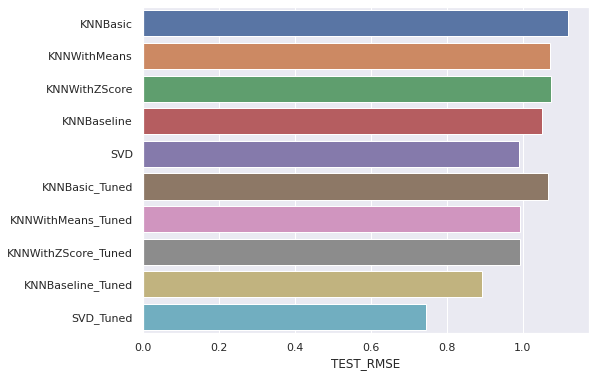

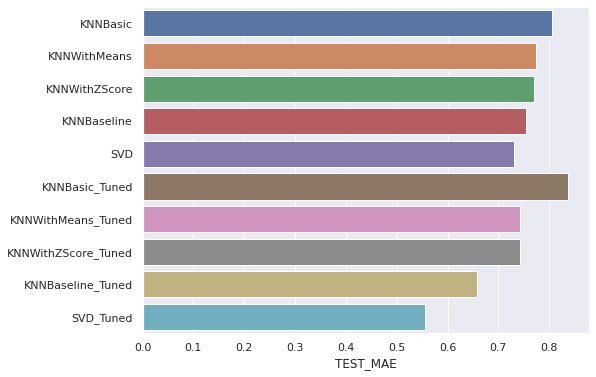

In [268]:
count=0
for i in modr_df.columns:
    count=count+1
    plt.figure(count,figsize=(8,6))
    sns.barplot(x=modr_df[i], y=modr_df[i].index)

In every aspect model based SVD Tuned algo is good compared to memory based algos. Lets use SVD for recommending to the users.

In [259]:
# release trainset and testset
del trainset
del testset

#### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. ( 10 marks)

In [340]:
# Since last tuned is SVD we can get the algo from gridsearch itself.
algo=gs.best_estimator['rmse']

In [261]:
# build anti testset which contains the user and item combinations for which info is not present in trainset
recommset=data.build_full_trainset().build_anti_testset()

In [271]:
# build collaborative recomm based on user-id
def collaborative_recomm(uid,k):
    user_item_set=[item for item in recommset if item[0] ==uid ]
    recomm_data=algo.test(user_item_set)
    uid=[i[0] for i in recomm_data]
    iid=[i[1] for i in recomm_data]
    rui=[i[3] for i in recomm_data]
    recomm_df=pd.DataFrame(data={'userId':uid,'productId':iid,'ratings':rui})
    return recomm_df.sort_values(by='ratings',ascending=False).head(k)

In [272]:
k=5
recomm=collaborative_recomm(uid='A3BY5KCNQZXV5U',k=k)
print(recomm)

               userId   productId   ratings
181    A3BY5KCNQZXV5U  B00007GQLS  4.889644
2421   A3BY5KCNQZXV5U  B0052SCU8U  4.811760
11010  A3BY5KCNQZXV5U  B004ELA0SS  4.782359
4785   A3BY5KCNQZXV5U  B007FGYZFI  4.778689
534    A3BY5KCNQZXV5U  B00IVPU6AA  4.772088


#### 8. Summarise your insights. ( 10 marks)


1. Most of the users have rated majority of the products between 4 and 5. And also there are some significant set of users who have rated majority of their purchased products with least rating 1.
2. Most of the products have their mean rating above 3 which is good. However the spike at rating 1 is alarming which needs to be taken care of.
3. Out of 7.8M purchases, around 1M purchases are rated below the user mean rating, indicating the product is bad. This amounts to around 12.8% of the purchases which is quite alarming and in depth survey needs to be done for these. Products which have got high number of bad ratings should be investigated first. The top 15 bad products are captured in our analysis by removing the user-bias.
4. Around 5.59M purchases are rated OK by customer(customer rating for that product is equal to customer mean rating). This is a good sign.
And around 1.23M purchases are rated good/highly appreciated.
5. Out of 4.2M Customer base, only 1.5k customers have purchased more than or equal to 50 times. 
6. These 1.5k high purchasing customers didn't even buy the top 10 purchased products. This is an important stat because if we try to make the dataset dense then these top 10 purchased products wouldn't even be considered further in the recommendations. So for popular recommendations, its better not to filter out any data and use the full dataset.
7. Model base algorithm - SVD serves as best model for this dataset for collaborative filtering.
8. In collaborative filtering by using 1.5k customers, only 48k products are considered. But in the store we have total of 476k. This indicates that only 10% of the products are considered in collaborative filtering. 
9. By considering Point#8, it would be better to check if content based recommendation is possible or not. Gather the product information for each item and do the content based recommendation. This can help business in recommending/selling the similar items.
10. Overall, I feel that initially we should proceed with Popular based recommendation and content based recommendations. This should be the first step. Next, in further stages, business can include collaborative filtering that we have developed above.